In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.stats as stat
#from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

46


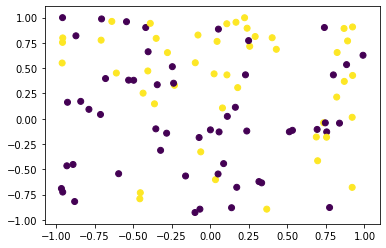

In [42]:
distorts = [
            lambda eta: eta, 
#             lambda eta:0.3+0.4*eta,
            lambda eta:stat.beta.cdf(eta,0.2,0.2),
            lambda eta:stat.beta.cdf(eta,5.,5.),
            lambda eta:stat.beta.cdf(eta,0.5,2),
            lambda eta:stat.beta.cdf(eta,2,0.5),
            lambda eta:stat.beta.cdf(eta,20,80)*0.25 +
                       stat.beta.cdf(eta,80,20)*0.25 + 
                       stat.beta.cdf(eta,0.1,0.1)*0.5,
            lambda eta:stat.beta.cdf(eta,30,10)*0.5 +
                       stat.beta.cdf(eta,0.1,0.1)*0.5
           ]

num_annots = len(distorts)

num_dp_per_annot = 100
num_test = 5000
data_dim = 64
w_star = 2.*np.ones((data_dim))
#print(w_star)
np.random.seed(100)
x_all_train = 2*np.random.rand(num_annots, num_dp_per_annot, data_dim)-1
eta_all_train = 1./(1+np.exp(-np.dot(x_all_train,w_star)))
y_all_train = 2*(np.random.rand(*eta_all_train.shape)<eta_all_train) - 1
#print(x_all_train.shape)
x_all_test = 2*np.random.rand(num_test, data_dim)-1
eta_all_test = 1./(1+np.exp(-np.dot(x_all_test,w_star)))
y_all_test = 2*(np.random.rand(*eta_all_test.shape)<eta_all_test) - 1

#print(y_all_test)
eta_tilde_all_train = np.array([distorts[i](eta_all_train[i]) for i in range(num_annots)])
y_tilde_all_train = 2*(np.random.rand(*eta_tilde_all_train.shape)<eta_tilde_all_train) - 1

eta_tilde_all_test = np.array([distorts[i](eta_all_test) for i in range(num_annots)])
y_tilde_all_test = 2*(np.random.rand(*eta_tilde_all_test.shape)<eta_tilde_all_test) - 1
#print(y_tilde_all_test.shape)

j=0
plt.scatter(x_all_train[j][:,0], x_all_train[j][:,1], c= y_all_train[j])

print(np.sum(y_all_train[j]==+1))

X_train_d = x_all_train
Y_train_d = y_tilde_all_train
Y_train_d = (Y_train_d + 1)//2
X_test_d = []
for i in range(num_annots):
    X_test_d.append(x_all_test)
X_test_d = np.array(X_test_d)
Y_test_d = y_tilde_all_test
Y_test_d = (Y_test_d + 1)//2
#print(Y_train_d)
#print(Y_test_d)
#print(X_train_d[1])

In [43]:
def accuracy_score(Y, Y_pred):
    loss = 0.0
    #print(Y.shape[0])
    for i in range(Y.shape[0]):
        loss = loss + ((Y[i]- Y_pred[i])**2)
    return loss/(Y.shape[0])
        

In [44]:
#Baseline-1
clf_list = []
accuracy_list = []
for i in range(X_train_d.shape[0]):
    #Y_train_d[i] =Y_train_d[i].astype('int')
    #Y_test_d[i] =Y_test_d[i].astype('int')
    clf = LogisticRegression(solver='lbfgs').fit(X_train_d[i], Y_train_d[i])
    Y_pred = clf.predict_proba(X_test_d[i])[:,1]
    #print(Y_pred)
    accuracy_list.append(accuracy_score(Y_test_d[i],Y_pred))
accuracy_list
#Y_test_distort[0].shape

[0.1697665130211012,
 0.1943933321638101,
 0.12474420695913564,
 0.13092115042736857,
 0.15551269124871522,
 0.24550069810582423,
 0.21852051087087435]

In [45]:
Z_train = list(range(num_annots))
Z_train_label = list(range(num_annots))
for i in range(num_annots):
    temp = []
    temp_label = []
    for j in range(len(X_train_d[i])):
        for k in range(j+1,len(X_train_d[i])):
            if(Y_train_d[i][j] != Y_train_d[i][k]):
                temp.append(X_train_d[i][j]-X_train_d[i][k] )
                temp_label.append((Y_train_d[i][j]- Y_train_d[i][k]+1)//2)
    Z_train[i] = np.array(temp)
    Z_train_label[i] = np.array(temp_label)

print(Z_train_label)


[array([0, 0, 0, ..., 1, 1, 0], dtype=int32), array([1, 1, 1, ..., 1, 0, 0], dtype=int32), array([1, 1, 1, ..., 0, 0, 0], dtype=int32), array([1, 1, 1, ..., 1, 1, 1], dtype=int32), array([0, 0, 0, ..., 1, 1, 1], dtype=int32), array([0, 0, 0, ..., 1, 0, 0], dtype=int32), array([0, 0, 0, ..., 0, 1, 1], dtype=int32)]


In [46]:
sr_clf_list = []
sr_accuracy_list = []
for i in range(num_annots):
    #Z_train_label[i] =Z_train_label[i].astype('int')
    #Y_test_d[i] =Y_test_d[i].astype('int')
    clf = LogisticRegression(solver='lbfgs').fit(Z_train[i], Z_train_label[i])
    sr_clf_list.append(clf)

In [47]:
sr_probab = list(range(num_annots))
iso_reg = list(range(num_annots))
for i in range(num_annots):
    sr_probab[i] = (sr_clf_list[i].predict_proba(X_train_d[i]))[:,1]
    iso_reg[i] = IsotonicRegression(out_of_bounds = 'clip').fit(sr_probab[i],Y_train_d[i])
    

In [48]:
Y_pred_sr = list(range(num_annots))
sr_accuracy_list = list(range(num_annots))
for i in range(num_annots):
    temp=  iso_reg[i].predict((sr_clf_list[i].predict_proba(X_test_d[i]))[:,1])
    #print(max(temp))
    sr_accuracy_list[i] = accuracy_score(Y_test_d[i],np.array(temp))
sr_accuracy_list

[0.20605533632635775,
 0.25126076237540235,
 0.1540328809503813,
 0.1572005034816159,
 0.18672201640475536,
 0.34192598557720905,
 0.28881683308383627]

In [49]:
#Joint Ranking (Training Phase)
Z_train = []
Z_train_label = []
temp  = []
temp_label = []
for i in range(num_annots):
    for j in range(len(X_train_d[i])):
        for k in range(j+1,len(X_train_d[i])):
            if(Y_train_d[i][j] != Y_train_d[i][k]):
                temp.append(X_train_d[i][j]-X_train_d[i][k] )
                temp_label.append((Y_train_d[i][j]- Y_train_d[i][k] + 1)//2)
Z_train = np.array(temp)
Z_train_label = np.array(temp_label)
                

In [50]:
#Logistic Regression separately for each labeller on the transformed data
jr_clf = 0
jr_accuracy = 0
#Z_train_label =Z_train_label.astype('int')
jr_clf = LogisticRegression(solver='lbfgs').fit(Z_train, Z_train_label)

In [51]:
jr_probab =list(range(num_annots))
iso_reg = list(range(num_annots))
for i in range(num_annots):
    jr_probab[i] = (jr_clf.predict_proba(X_train_d[i]))[:,1]  # sigma(w^T(x))
    iso_reg[i] = IsotonicRegression(out_of_bounds = 'clip').fit(jr_probab[i],Y_train_d[i]) #u_i(sigma(w^T(x)))
    

In [52]:
#Joint Raking Testing Phase
Y_pred_jr = list(range(num_annots))
jr_accuracy_list = list(range(num_annots))
for i in range(num_annots):
    temp=  iso_reg[i].predict((jr_clf.predict_proba(X_test_d[i]))[:,1]) #u_i(sigma(w^T(x)))
    
    jr_accuracy_list[i] = accuracy_score(Y_test_d[i],np.array(temp)) #loss calculation
jr_accuracy_list

[0.08859261868082262,
 0.16663848073674709,
 0.08689566727000152,
 0.1030709641169246,
 0.10466930364268341,
 0.16017590113569494,
 0.15853222356573596]

In [53]:
#Separate Slisotron(Training Phase)
T = 1000 # no. of iterations
u = list(range(num_annots))   # distortion applied by each annotator
w = []          #weight vector for each annotator
for i in range(num_annots):
    w.append(np.zeros(data_dim))   # Initialisation of w
for i in range(num_annots):
    for t in range(T):
        temp = []
        for x in X_train_d[i]:
            temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w[i]),x)))))  #(sigma(w_i^T(x)))
        temp = np.array(temp)
        u[i] = IsotonicRegression(out_of_bounds = 'clip').fit(temp,Y_train_d[i]) #updating u(Isotonic Regression)
        iso_predict = u[i].predict(temp) #(u_i(sigma(w_i^T(x)))
        sum1 = 0
        for j in range(len(X_train_d[i])):
            sum1 = sum1 + (Y_train_d[i][j] - iso_predict[j])*(X_train_d[i][j])
        sum1 = sum1/len(X_train_d[i])
        w[i] = w[i] + sum1  #updating w
    print(w[i])
    

[ 0.05352153  0.11152167  0.00305189  0.00695525  0.0418033   0.0243759
  0.07183205 -0.05315327  0.04010841  0.01792722  0.02628814  0.038767
  0.03598909 -0.02094886  0.03193036 -0.01060811  0.01981986  0.07718948
  0.04533716  0.02405771  0.05905105  0.02418937  0.0162568   0.04916241
  0.05480215  0.04516358  0.05613333  0.07731082  0.00402232  0.00349591
  0.06360415  0.01214581  0.04120302  0.01740303  0.04386756  0.0538132
  0.08929145  0.00452706  0.03775612  0.01332855  0.01748072  0.02845961
  0.02862033 -0.00248541  0.00130981 -0.01402818  0.00128325  0.02718407
  0.01597217  0.06387097  0.04477538  0.08414711  0.06050114 -0.0191637
  0.05645191  0.04557921  0.01874828  0.00659023  0.09092266  0.05273154
  0.00346447 -0.00064086  0.09875155  0.01280955]
[-0.01616776  0.02413482  0.05545933 -0.00293269  0.06688645  0.0447192
  0.03445804  0.05667973  0.03139503  0.05463011  0.00525522  0.06933758
 -0.02279304 -0.0080008   0.04594958  0.03483112  0.01555076  0.02325537
  0.018

In [55]:
#Separate Slisotron(Testing Phase)
sl_accuracy_list = list(range(num_annots))
Y_pred_sl = list(range(num_annots))
for i in range(num_annots):
    pred_class = []
    temp = []
    for x in X_test_d[i]:
        temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w[i]),x)))))     #(sigma(w_i^T(x)))
    temp = np.array(temp)
    pred_prob = u[i].predict(temp)           #(u_i(sigma(w_i^T(x)))
    sl_accuracy_list[i] = (accuracy_score(Y_test_d[i],np.array(pred_prob))) #loss calculation
    
sl_accuracy_list
            
        

[0.23219561651173218,
 0.3092606797561974,
 0.20597847576382436,
 0.21191677735417574,
 0.24139226888334925,
 0.3600116081880635,
 0.2871818230513943]

In [56]:
#Joint Slisotron (Training Phase)
T = 100
u = list(range(num_annots))
w = 0           #same 'w' for all labellers
for i in range(num_annots):
    w = np.array(np.zeros(data_dim))
for t in range(T):
    sum1 = 0
    for i in range(num_annots):
        temp = []
        for x in X_train_d[i]:
            temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w),x)))))   #calculating sigma(w_T(x))
        temp = np.array(temp)
        u[i] = IsotonicRegression(out_of_bounds = 'clip').fit(temp,Y_train_d[i])  # updating u_i using isotonic regression
        
        iso_predict = u[i].predict(temp)     # u_i(sigma(w_T(x)))
        for j in range(len(X_train_d[i])):
            sum1 = sum1 + (Y_train_d[i][j] - iso_predict[j])*(X_train_d[i][j])
    sum1 = sum1/(len(X_train_d[0])*num_annots)
    w = w + sum1  #updating 'w' considering all four labellers
print(w)
    

[0.01643414 0.0137453  0.0205559  0.01418191 0.02412857 0.02928212
 0.02788989 0.02498833 0.02094053 0.03013322 0.01245535 0.02115988
 0.0097754  0.0179749  0.02280469 0.02354    0.01575201 0.02085876
 0.02430101 0.0179748  0.02434109 0.01894277 0.01699073 0.02996512
 0.01774193 0.01615647 0.01882274 0.02389316 0.00855401 0.01540917
 0.02341877 0.00654729 0.01640593 0.03135612 0.02326987 0.01492352
 0.01666247 0.01497868 0.03312851 0.03425917 0.01271029 0.03430489
 0.01679263 0.02635554 0.02177652 0.00494939 0.02729883 0.01792863
 0.01771189 0.01694485 0.02707903 0.01521105 0.00592969 0.0046387
 0.01450758 0.03001599 0.02623347 0.01817308 0.01683202 0.02671331
 0.01182475 0.02478047 0.02712374 0.00800298]


In [58]:
sl_accuracy_list = list(range(num_annots))
Y_pred_sl = list(range(num_annots))
for i in range(num_annots):
    pred_class = []
    temp = []
    for x in X_test_d[i]:
        temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w),x)))))
    temp = np.array(temp)
    pred_prob = u[i].predict(temp)
    for j in range(len(X_test_d[i])):
        if(pred_prob[i] >=0.5):
            pred_class.append(1)
        else:
            pred_class.append(0)
    pred_class = np.array(pred_class)
    Y_pred_sl[i] = pred_class
    sl_accuracy_list[i] = (accuracy_score(Y_test_d[i],np.array(pred_prob)))
    
sl_accuracy_list

[0.10020757013524119,
 0.16423171704918202,
 0.08144830883820102,
 0.1046989483741062,
 0.11200696242345025,
 0.15767312911152265,
 0.15595176030150854]